In [1]:
import sklearn
import torch
import transformers
import peft
import tqdm
import math
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorWithPadding, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score, roc_curve, auc
from peft import LoraConfig, TaskType, get_peft_model, IA3Config

## Load Models

In [2]:
tokenizer = AutoTokenizer.from_pretrained("gagneurlab/SpeciesLM", revision="downstream_species_lm")
lm = AutoModelForMaskedLM.from_pretrained("gagneurlab/SpeciesLM", revision="downstream_species_lm")

device = "cuda" if torch.cuda.is_available() else "cpu"
lm.eval()
lm.to(device)
print(f"Load pretrained model to device {device}")

Load pretrained model to device cuda


In [45]:
lm

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5504, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## Prepare Dataset

In [3]:
dataset = load_dataset(path="InstaDeepAI/nucleotide_transformer_downstream_tasks", 
                        name="promoter_no_tata", trust_remote_code=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'name', 'label'],
        num_rows: 47767
    })
    test: Dataset({
        features: ['sequence', 'name', 'label'],
        num_rows: 5299
    })
})

In [4]:
dataset['train'][0]

{'sequence': 'ATAAAGCAACAGGAGGACACCGGCTCTCGCGTCATTAGGTCACACAATGTCTCAGTTTAAGGCGGGTGGGGTGGGCCAGACTCACAGCTGAGATAGAATTATTGCGAGATAACTCTGTTTAAGTAGCTAGGCTTGAAAATGGACGGTGAGTACCCTAGGACGTGCCCCAGGGCCAGTGGGATAAAGGTACACGCCGGCGGGGGCATGAGTCAGGGGTTTGCGAGCGAAAAAAGGAGCATTGGTTGCTACTGCGTTAGTGGGAACGTAGCTGGTCGCAGAGGGCACCTAATGCTGGCACCC',
 'name': 'SLC4A1_1(-)|no_TATA|0',
 'label': 0}

In [4]:
train_valid_split = dataset['train'].train_test_split(test_size=0.15, seed=42)

train_valid_split = DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['test']
})

ds = DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['validation'],
    'test': dataset['test']
})

In [5]:
def get_kmers(seq, k=6, stride=1):
    return [seq[i:i + k] for i in range(0, len(seq), stride) if i + k <= len(seq)]

In [6]:
def get_dataset(ds):
    test_sequences = []
    train_sequences = []
    val_sequences = []
    
    for i in range(0, len(ds['train'])):
    
        sequence = ds['train'][i]['sequence']
        sequence = "candida_glabrata " + " ".join(get_kmers(sequence))
        sequence = tokenizer(sequence)["input_ids"]
        train_sequences.append(sequence)
    
    for i in range(0, len(ds['validation'])):
        sequence = ds['validation'][i]['sequence']
        sequence = "candida_glabrata " + " ".join(get_kmers(sequence))
        sequence = tokenizer(sequence)["input_ids"]
        val_sequences.append(sequence)
    
    
    for i in range(0, len(ds['test'])):
        sequence = ds['test'][i]['sequence']
        sequence = "candida_glabrata " + " ".join(get_kmers(sequence))
        sequence = tokenizer(sequence)["input_ids"]
        test_sequences.append(sequence)
    
    
    train_labels = ds['train']['label']
    test_labels = ds['test']['label']
    val_labels = ds['validation']['label']
    
    a = {"input_ids": train_sequences, "labels": train_labels}
    df = pd.DataFrame.from_dict(a)
    train_dataset = Dataset.from_pandas(df)
    
    b = {"input_ids": val_sequences, "labels": val_labels}
    df = pd.DataFrame.from_dict(b)
    val_dataset = Dataset.from_pandas(df)
    
    c = {"input_ids": test_sequences, "labels": test_labels}
    df = pd.DataFrame.from_dict(c)
    test_dataset = Dataset.from_pandas(df)
    
    total = len(train_dataset)+len(val_dataset)+len(test_dataset)
    
    print(f"""# of Train set: {len(train_dataset)} ({round(len(train_dataset)/total,2)})
    # of Validation set: {len(val_dataset)} ({round(len(val_dataset)/total,2)})
    # of Test set: {len(test_dataset)}({round(len(test_dataset)/total,2)})""")
    return train_dataset, val_dataset, test_dataset, train_labels, val_labels, test_labels


In [7]:
train_dataset, val_dataset, test_dataset, train_labels, val_labels, test_labels = get_dataset(ds)

# of Train set: 40601 (0.77)
    # of Validation set: 7166 (0.14)
    # of Test set: 5299(0.1)


## Set Up Model

In [8]:
# free model weights
for param in lm.parameters():
  param.requires_grad = False

In [9]:
class DNA_LM(nn.Module):
    def __init__(self, model, num_labels):
        super(DNA_LM, self).__init__()
        self.model = model.bert  # take only the encoder
        self.in_features = self.model.config.hidden_size
        self.out_features = num_labels
        self.classifier = nn.Linear(self.in_features, self.out_features)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             output_hidden_states=True)
        sequence_output = outputs.last_hidden_state
        # Use the [CLS] token for classification
        cls_output = sequence_output[:, 0, :]
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.out_features), labels.view(-1))

        return (loss, logits) if loss is not None else logits

num_labels = 2

In [10]:
# Number of classes for your classification task

batch_size = 128
num_labels = 2
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
epochs = 5
weight_decay = 1e-2
learning_rate = 1e-3

In [12]:
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/baseline',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.376300,0.414736
2,0.310200,0.379471
3,0.418700,0.374253
4,0.277000,0.368297
5,0.345500,0.366134


TrainOutput(global_step=1590, training_loss=0.37085412751953556, metrics={'train_runtime': 947.6153, 'train_samples_per_second': 214.227, 'train_steps_per_second': 1.678, 'total_flos': 0.0, 'train_loss': 0.37085412751953556, 'epoch': 5.0})

## Predict using baseline model

In [11]:
def sklearn_eval(test_labels, predicted_labels):
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")
    
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    roc_score = roc_auc_score(test_labels, predicted_labels)
    print(f"AUC ROC score: {roc_score:.4f}")

    target_names = ['Class 0', 'Class 1']
    print(classification_report(test_labels, predicted_labels, target_names=target_names))

In [12]:
def plot_roc(test_labels, predicted_labels):
  fpr, tpr, thresholds = roc_curve(test_labels, predicted_labels, pos_label = 1)

  # AUC score that summarizes the ROC curve
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
  plt.plot([0, 1], [0, 1],
          linestyle = '--',
          color = (0.6, 0.6, 0.6),
          label = 'random guessing')
  plt.plot([0, 0, 1], [0, 1, 1],
          linestyle = ':',
          color = 'black', 
          label = 'perfect performance')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.title('Receiver Operator Characteristic')
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

In [15]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels_baseline = logits.argmax(axis=-1)

In [16]:
sklearn_eval(test_labels, predicted_labels_baseline)

Accuracy: 0.8313
Precision: 0.8352
Recall: 0.8313
F1-Score: 0.8307
AUC ROC score: 0.8308
              precision    recall  f1-score   support

     Class 0       0.80      0.89      0.84      2671
     Class 1       0.87      0.77      0.82      2628

    accuracy                           0.83      5299
   macro avg       0.84      0.83      0.83      5299
weighted avg       0.84      0.83      0.83      5299



In [18]:
import pickle

with open('non-tata_baseline_predicted_labels.pkl', 'wb') as f:
    pickle.dump(predicted_labels_baseline, f)

In [22]:
with open('non-tata_baseline_predicted_labels.pkl', 'rb') as f:
    predicted_labels_baseline = pickle.load(f)

In [23]:
predicted_labels_baseline[:10]

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

## Finetune pre-trained model for Downstream Task

### Lora rank=2

In [17]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=2,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 110,592 || all params: 89,789,954 || trainable%: 0.1232


In [16]:
lora_model

PeftModel(
  (base_model): LoraModel(
    (model): DNA_LM(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(5504, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=2, bias

In [18]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/lora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.164500,No log
2,0.048300,No log
3,0.009500,No log
4,0.033200,No log
5,0.009800,No log


TrainOutput(global_step=1590, training_loss=0.11119051163360101, metrics={'train_runtime': 1889.1237, 'train_samples_per_second': 107.46, 'train_steps_per_second': 0.842, 'total_flos': 0.0, 'train_loss': 0.11119051163360101, 'epoch': 5.0})

In [21]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora2)

Accuracy: 0.9611
Precision: 0.9621
Recall: 0.9611
F1-Score: 0.9611
AUC ROC score: 0.9609
              precision    recall  f1-score   support

     Class 0       0.94      0.98      0.96      2671
     Class 1       0.98      0.94      0.96      2628

    accuracy                           0.96      5299
   macro avg       0.96      0.96      0.96      5299
weighted avg       0.96      0.96      0.96      5299



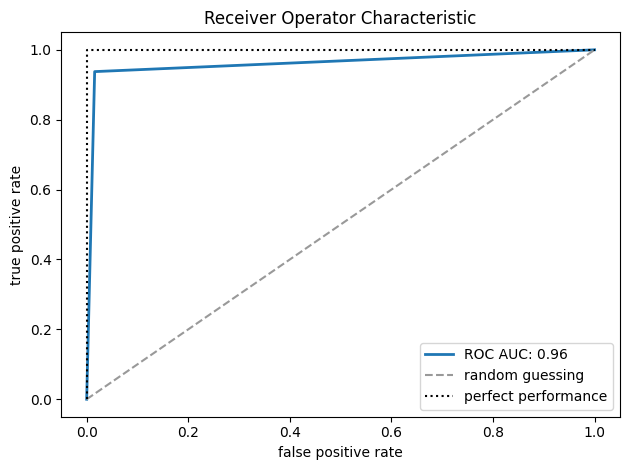

In [23]:
plot_roc(test_labels, predicted_labels_lora2)

### LoRA rank=4

In [ ]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=4,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora4 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora4)

In [25]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora4 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora4)

Accuracy: 0.9649
Precision: 0.9655
Recall: 0.9649
F1-Score: 0.9649
AUC ROC score: 0.9647
              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      2671
     Class 1       0.98      0.95      0.96      2628

    accuracy                           0.96      5299
   macro avg       0.97      0.96      0.96      5299
weighted avg       0.97      0.96      0.96      5299



### LoRA r=16

In [13]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/lora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora_16 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora_16)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 884,736 || all params: 90,564,098 || trainable%: 0.9769


Epoch,Training Loss,Validation Loss
1,0.024800,No log
2,0.032200,No log
3,0.019900,No log
4,0.022600,No log
5,0.011600,No log


Accuracy: 0.9658
Precision: 0.9668
Recall: 0.9658
F1-Score: 0.9658
AUC ROC score: 0.9657
              precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97      2671
     Class 1       0.99      0.94      0.96      2628

    accuracy                           0.97      5299
   macro avg       0.97      0.97      0.97      5299
weighted avg       0.97      0.97      0.97      5299



### lora r=32

In [14]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=32,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/lora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora_32 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora_32)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 1,769,472 || all params: 91,448,834 || trainable%: 1.9349


Epoch,Training Loss,Validation Loss
1,0.071000,No log
2,0.027000,No log
3,0.013800,No log
4,0.029500,No log
5,0.008700,No log


Accuracy: 0.9643
Precision: 0.9649
Recall: 0.9643
F1-Score: 0.9643
AUC ROC score: 0.9642
              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      2671
     Class 1       0.98      0.95      0.96      2628

    accuracy                           0.96      5299
   macro avg       0.97      0.96      0.96      5299
weighted avg       0.96      0.96      0.96      5299



## Dora Model
### DoRA rank=4

In [26]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    use_dora=True,
    r=4,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

trainable params: 248,832 || all params: 89,928,194 || trainable%: 0.2767


In [27]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.167100,No log
2,0.024200,No log
3,0.010100,No log
4,0.020800,No log
5,0.007300,No log


TrainOutput(global_step=1590, training_loss=0.10618056845294792, metrics={'train_runtime': 2370.8164, 'train_samples_per_second': 85.627, 'train_steps_per_second': 0.671, 'total_flos': 0.0, 'train_loss': 0.10618056845294792, 'epoch': 5.0})

In [29]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora4 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora4)

Accuracy: 0.9643
Precision: 0.9652
Recall: 0.9643
F1-Score: 0.9643
AUC ROC score: 0.9642
              precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97      2671
     Class 1       0.99      0.94      0.96      2628

    accuracy                           0.96      5299
   macro avg       0.97      0.96      0.96      5299
weighted avg       0.97      0.96      0.96      5299



### DoRA rank=2

In [11]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    use_dora=True,
    r=2,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

trainable params: 138,240 || all params: 89,817,602 || trainable%: 0.1539


In [12]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.091500,No log
2,0.091800,No log
3,0.023200,No log
4,0.018700,No log
5,0.011900,No log


TrainOutput(global_step=1590, training_loss=0.10826307068163026, metrics={'train_runtime': 2368.5496, 'train_samples_per_second': 85.709, 'train_steps_per_second': 0.671, 'total_flos': 0.0, 'train_loss': 0.10826307068163026, 'epoch': 5.0})

In [16]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora_2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora_2)

Accuracy: 0.9636
Precision: 0.9647
Recall: 0.9636
F1-Score: 0.9635
AUC ROC score: 0.9634
              precision    recall  f1-score   support

     Class 0       0.94      0.99      0.96      2671
     Class 1       0.99      0.94      0.96      2628

    accuracy                           0.96      5299
   macro avg       0.96      0.96      0.96      5299
weighted avg       0.96      0.96      0.96      5299



## DoRA r=16

In [15]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    use_dora=True,
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora_16 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora_16)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 912,384 || all params: 90,591,746 || trainable%: 1.0071


Epoch,Training Loss,Validation Loss
1,0.032000,No log
2,0.060700,No log
3,0.020100,No log
4,0.034900,No log
5,0.015700,No log


Accuracy: 0.9657
Precision: 0.9660
Recall: 0.9657
F1-Score: 0.9656
AUC ROC score: 0.9655
              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      2671
     Class 1       0.98      0.95      0.96      2628

    accuracy                           0.97      5299
   macro avg       0.97      0.97      0.97      5299
weighted avg       0.97      0.97      0.97      5299



### DoRA r=32

In [16]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    use_dora=True,
    r=32,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora_32 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora_32)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 1,797,120 || all params: 91,476,482 || trainable%: 1.9646


Epoch,Training Loss,Validation Loss
1,0.032400,No log
2,0.033300,No log
3,0.033300,No log
4,0.035000,No log
5,0.006300,No log


Accuracy: 0.9640
Precision: 0.9647
Recall: 0.9640
F1-Score: 0.9639
AUC ROC score: 0.9638
              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96      2671
     Class 1       0.98      0.94      0.96      2628

    accuracy                           0.96      5299
   macro avg       0.96      0.96      0.96      5299
weighted avg       0.96      0.96      0.96      5299



### IA3

In [17]:
config = IA3Config(
    # peft_type="IA3",
    task_type=TaskType.FEATURE_EXTRACTION,
    # target_modules=["query", "key", "value"],
    # feedforward_modules=["w0"],
)

ia3_model = get_peft_model(lm, config)
ia3_model.to(device)
ia3_model = DNA_LM(ia3_model, num_labels)
ia3_model.to(device)

DNA_LM(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5504, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=7

In [18]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/ia3',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=ia3_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.001500,0.156822
2,0.001100,0.125671
3,0.008100,0.127764
4,0.008100,0.137851
5,0.002300,0.133075


TrainOutput(global_step=1590, training_loss=0.0461290545590257, metrics={'train_runtime': 2471.0852, 'train_samples_per_second': 82.152, 'train_steps_per_second': 0.643, 'total_flos': 0.0, 'train_loss': 0.0461290545590257, 'epoch': 5.0})

In [19]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels_ia3 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_ia3)

Accuracy: 0.9638
Precision: 0.9646
Recall: 0.9638
F1-Score: 0.9637
AUC ROC score: 0.9636
              precision    recall  f1-score   support

     Class 0       0.94      0.99      0.96      2671
     Class 1       0.98      0.94      0.96      2628

    accuracy                           0.96      5299
   macro avg       0.96      0.96      0.96      5299
weighted avg       0.96      0.96      0.96      5299



### AUROC Curve

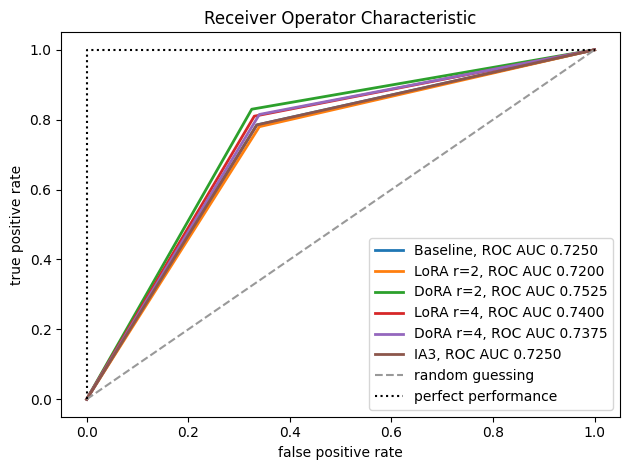

In [53]:
fpr0, tpr0, thresholds = roc_curve(test_labels, predicted_labels_baseline, pos_label = 1)
fpr1, tpr1, thresholds = roc_curve(test_labels, predicted_labels, pos_label = 1)
fpr2, tpr2, thresholds = roc_curve(test_labels, predicted_labels_dora_2, pos_label = 1)
fpr3, tpr3, thresholds = roc_curve(test_labels, predicted_labels_lora4, pos_label = 1)
fpr4, tpr4, thresholds = roc_curve(test_labels, predicted_labels_dora4, pos_label = 1)
fpr5, tpr5, thresholds = roc_curve(test_labels, predicted_labels_ia3, pos_label = 1)

# AUC score that summarizes the ROC curve
roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)

plt.plot(fpr0, tpr0, lw = 2, label='Baseline, ROC AUC {:.4f}'.format(roc_auc0))
plt.plot(fpr1, tpr1, lw = 2, label='LoRA r=2, ROC AUC {:.4f}'.format(roc_auc1))
plt.plot(fpr2, tpr2, lw = 2, label='DoRA r=2, ROC AUC {:.4f}'.format(roc_auc2))
plt.plot(fpr3, tpr3, lw = 2, label='LoRA r=4, ROC AUC {:.4f}'.format(roc_auc3))
plt.plot(fpr4, tpr4, lw = 2, label='DoRA r=4, ROC AUC {:.4f}'.format(roc_auc4))
plt.plot(fpr5, tpr5, lw = 2, label='IA3, ROC AUC {:.4f}'.format(roc_auc5))

plt.plot([0, 1], [0, 1],
      linestyle = '--',
      color = (0.6, 0.6, 0.6),
      label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
      linestyle = ':',
      color = 'black', 
      label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

## Different LR & Accuracy Performance

In [27]:
learning_rate = 1e-2

In [28]:
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/baseline',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.662300,0.694903
2,0.707000,0.694963
3,0.692600,0.993297
4,0.674000,0.696598
5,0.712900,0.693607


TrainOutput(global_step=1590, training_loss=0.9512650805074464, metrics={'train_runtime': 2429.0108, 'train_samples_per_second': 83.575, 'train_steps_per_second': 0.655, 'total_flos': 0.0, 'train_loss': 0.9512650805074464, 'epoch': 5.0})

In [29]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels_baseline = logits.argmax(axis=-1)

sklearn_eval(test_labels,predicted_labels_baseline)

Accuracy: 0.4959
Precision: 0.2460
Recall: 0.4959
F1-Score: 0.3288
AUC ROC score: 0.5000
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      2671
     Class 1       0.50      1.00      0.66      2628

    accuracy                           0.50      5299
   macro avg       0.25      0.50      0.33      5299
weighted avg       0.25      0.50      0.33      5299



/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [30]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora2)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 2,092,032 || all params: 91,835,906 || trainable%: 2.2780


Epoch,Training Loss,Validation Loss
1,0.710100,No log
2,0.700500,No log
3,0.678700,No log
4,0.673300,No log
5,0.702300,No log


Accuracy: 0.4959
Precision: 0.2460
Recall: 0.4959
F1-Score: 0.3288
AUC ROC score: 0.5000
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      2671
     Class 1       0.50      1.00      0.66      2628

    accuracy                           0.50      5299
   macro avg       0.25      0.50      0.33      5299
weighted avg       0.25      0.50      0.33      5299



/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [31]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=16,
    use_dora=True,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora2)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 2,110,464 || all params: 91,854,338 || trainable%: 2.2976


Epoch,Training Loss,Validation Loss
1,0.680000,No log
2,0.688400,No log
3,0.648700,No log
4,0.680100,No log
5,0.698900,No log


Accuracy: 0.4959
Precision: 0.2460
Recall: 0.4959
F1-Score: 0.3288
AUC ROC score: 0.5000
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      2671
     Class 1       0.50      1.00      0.66      2628

    accuracy                           0.50      5299
   macro avg       0.25      0.50      0.33      5299
weighted avg       0.25      0.50      0.33      5299



/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [32]:
learning_rate = 1e-4

In [ ]:
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/baseline',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels_baseline = logits.argmax(axis=-1)

sklearn_eval(test_labels,predicted_labels_baseline)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.702400,0.693139
2,0.685200,0.693363
3,0.670300,0.693249


In [ ]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora2)

In [ ]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=16,
    use_dora=True,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print(learning_rate)
trainer.train()

predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora2)